In [2]:
# %load ../jupyter_setup.txt
# Convenient jupyter setup
%load_ext autoreload
%autoreload 2
%config IPCompleter.greedy=True
%config IPCompleter.use_jedi=False 

import os
import pathlib
import logging
from typing import Optional, Union
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm

# Custom utils for rasterio
from src.utils import get_byte_size
# Path to ESA Landcover datasets on Jasmin
from src.constants import ESA_LANDCOVER_DIR, GWS_DATA_DIR, WGS84

# Initialise the logging:
logger = logging.getLogger()
logger.setLevel(logging.INFO)

In [3]:
UTM35N = "EPSG:32635" 

# 1. Loading data

In [4]:
# Parse land cover classes:
landcover_classes = ESA_LANDCOVER_DIR / "ESACCI-LC-Legend.csv"
classes = pd.read_csv(landcover_classes, delimiter=";", index_col=0)

print(f"There are {len(classes)} classes.")
print(classes.head())

There are 38 classes.
                                 LCCOwnLabel    R    G    B
NB_LAB                                                     
0                                    No data    0    0    0
10                         Cropland, rainfed  255  255  100
11                          Herbaceous cover  255  255  100
12                       Tree or shrub cover  255  255    0
20      Cropland, irrigated or post-flooding  170  240  240


In [5]:
import xarray as xr
data_path = GWS_DATA_DIR / "esa_cci_zonal_analysis" / "esa_cci_zonal_class_analysis_full_data.nc"
data = xr.open_dataset(data_path).to_array()[0]
# Getting yearly effective meshsize of class 10 in zone E+60:
data.loc[{"zone":"E+60", 
          "cci_landcover_class":10, 
          "metric": "effective_mesh_size"}]

<xarray.DataArray (year: 24)>
array([56275.09475968, 56265.15176492, 56233.08742106, 57320.6252588 ,
       56424.50344157, 57547.94882152, 57546.93171478, 52324.71690765,
       52241.99497844, 52028.38971913, 51766.64613224, 51482.04670324,
       49860.83947756, 49776.66039719, 49712.2776736 , 49648.77338749,
       49508.40912532, 49457.72796208, 49443.81576023, 49425.75426012,
       49420.59418538, 49387.15713962, 49336.7018472 , 49336.7018472 ])
Coordinates:
    metric               <U19 'effective_mesh_size'
  * year                 (year) int16 1992 1993 1994 1995 ... 2013 2014 2015
    cci_landcover_class  int32 10
    zone                 <U4 'E+60'
    variable             <U29 '__xarray_dataarray_variable__'

In [6]:
data.loc[{"zone":"Polesie Exclusion Zone", 
          "cci_landcover_class":190, 
          "metric": "effective_mesh_size"}]

<xarray.DataArray (year: 24)>
array([nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan])
Coordinates:
    metric               <U19 'effective_mesh_size'
  * year                 (year) int16 1992 1993 1994 1995 ... 2013 2014 2015
    cci_landcover_class  int32 190
    zone                 <U22 'Polesie Exclusion Zone'
    variable             <U29 '__xarray_dataarray_variable__'

# 2. Plotting the class metrics during the period

In [7]:
def display_class_metric(zone: str, 
                         landcover_class: Union[int, str], 
                         metrics: str,
                         fig = None, 
                         **kwargs):
    
    '''Plot the temporal variation of class metrics for different class value'''
    # Input parsing        
    if isinstance(metrics, str):
        metrics = [metrics]
        
    if isinstance(landcover_class, str):
        # Deal with string labels
        assert landcover_class in classes.LCCOwnLabel.values
        landcover_class = classes[classes.LCCOwnLabel == landcover_class].index[0]
    
    # Create figure if necessary
    if not fig:
        plt.figure(figsize=(5,2))
        
    for metric in metrics:
        metric_name = metric.replace("_", " ").capitalize()
        class_name = classes.loc[landcover_class].LCCOwnLabel
        
        plot_title = f"{metric_name}: {class_name}({landcover_class})\n {zone}"
        
        plt.title(plot_title)
        
        plt.plot(data.year, 
                 data.loc[{"zone" : zone, 
                           "cci_landcover_class": landcover_class, 
                           "metric": metric
                          }],
                 linestyle="dashed",
                 marker=".")

The four seperated areas are studied in this whole region:

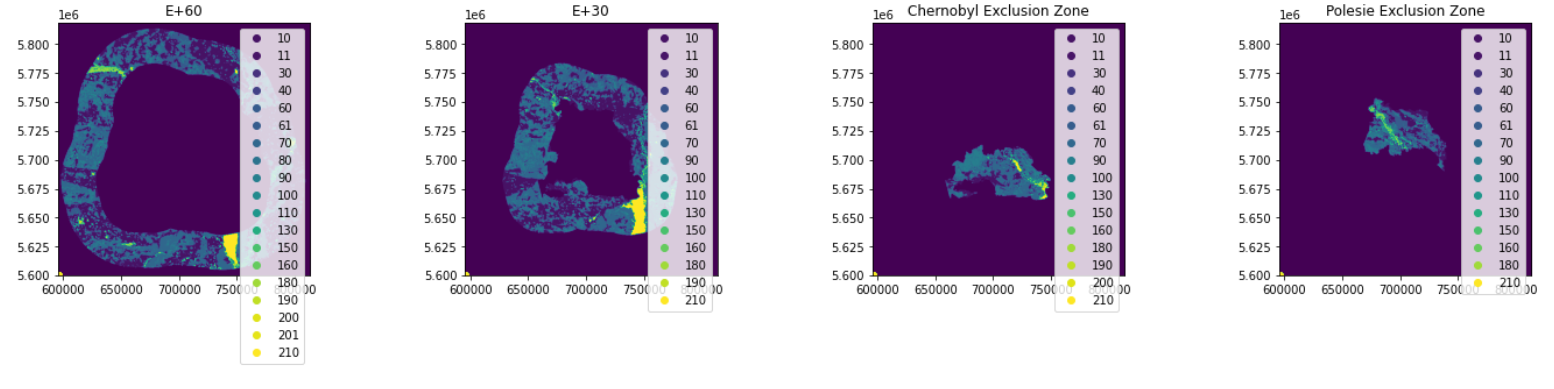

The regions of interest are classified as:
1. Combination of the exlcusion zones (representing no human impact): Chernobyl Exclusion Zone (CEZ) and Polesie Exclusion Zone (PEZ)
2. 30 km buffer around the exclusion zones (representing reduced human impact): E+30
3. 60 km buffer around the exclusion zones (representing mostly normal human impact): E+60

## 2.1 Plotting the metrics of 4 areas

### 2.1.1 Cropland, rainfed

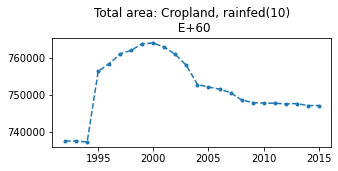

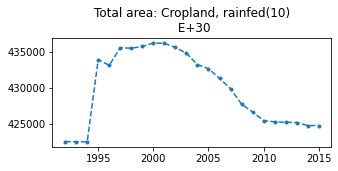

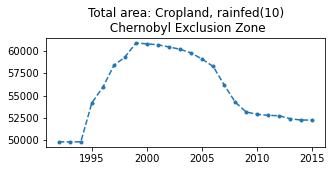

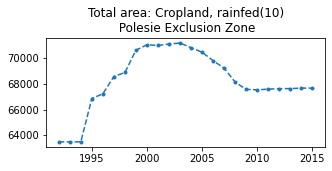

In [11]:
display_class_metric("E+60", 10, "total_area")
display_class_metric("E+30", 10, "total_area")
display_class_metric("Chernobyl Exclusion Zone", 10, "total_area")
display_class_metric("Polesie Exclusion Zone", 10, "total_area")

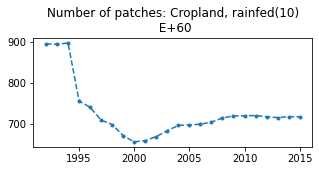

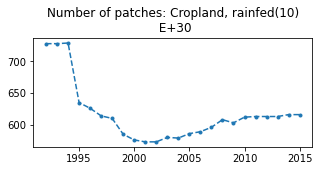

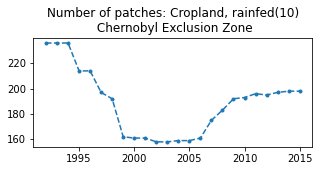

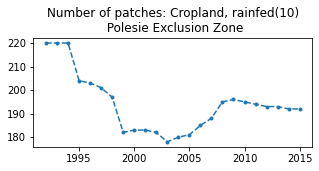

In [12]:
display_class_metric("E+60", 10, "number_of_patches")
display_class_metric("E+30", 10, "number_of_patches")
display_class_metric("Chernobyl Exclusion Zone", 10, "number_of_patches")
display_class_metric("Polesie Exclusion Zone", 10, "number_of_patches")


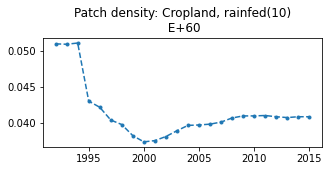

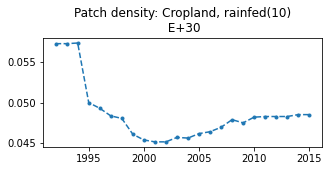

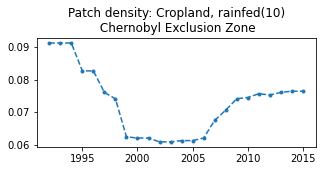

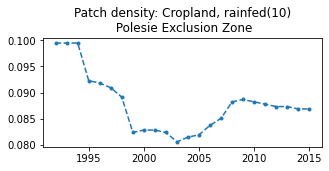

In [20]:
display_class_metric("E+60", 10, "patch_density")
display_class_metric("E+30", 10, "patch_density")
display_class_metric("Chernobyl Exclusion Zone", 10, "patch_density")
display_class_metric("Polesie Exclusion Zone", 10, "patch_density")

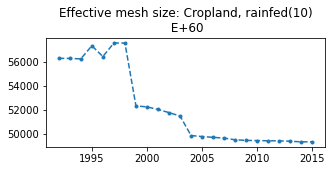

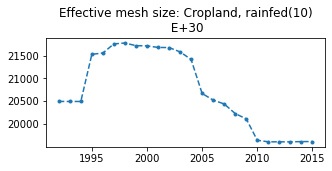

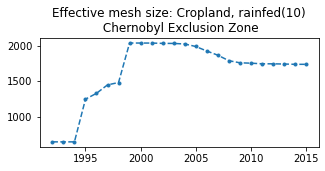

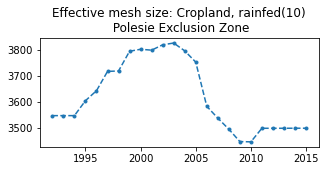

In [13]:
display_class_metric("E+60", 10, "effective_mesh_size")
display_class_metric("E+30", 10, "effective_mesh_size")
display_class_metric("Chernobyl Exclusion Zone", 10, "effective_mesh_size")
display_class_metric("Polesie Exclusion Zone", 10, "effective_mesh_size")

For E+60 and E+30 areas, MESH for rainfed croplands experienced a growth and then dropped to the lowest value, representing that the croplands in the two areas became more fragmented in recent years.



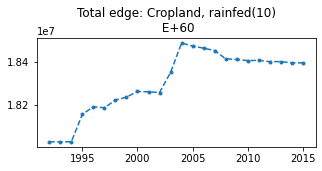

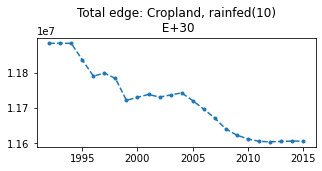

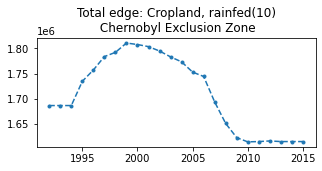

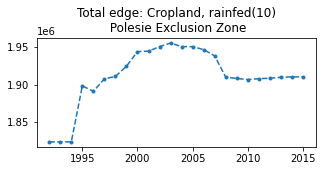

In [19]:
display_class_metric("E+60", 10, "total_edge")
display_class_metric("E+30", 10, "total_edge")
display_class_metric("Chernobyl Exclusion Zone", 10, "total_edge")
display_class_metric("Polesie Exclusion Zone", 10, "total_edge")

For the two buffer areas, the total areas of rainfed cropland rapidly increased in 1995 and then had a moderate growth until arond 2000. AS for two exclusion zones, the farmland areas experienced a continuous growth from 1994 to around 2000. E+60, the mostly normal human impacted area, had the greatest increase with more than 20000 ha, compared to the increase of roughly 10000 ha for the rest three areas. Moreover, considered the reduced number of patches and the decreasing landscape shape index (LSI) from 1995 to 2000, the small croplands tended to merge together and became a larger one. After 2000, the total area of rainfed croplands in the four regions started to decrease. 

MESH of Chernobyl Exclusion Zone demonstrated the defragmentation of the cropland. According to ,ESH, in both buffer area, the cropland tended to be defragmented before 2000 but then became more fragmented. For PEZ, MESH had a growing trend before around 2003, indicating the defragmentation, but decreased dramatically after 2005

### 2.1.2 Herbaceous cover

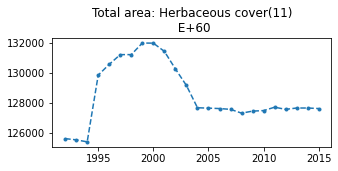

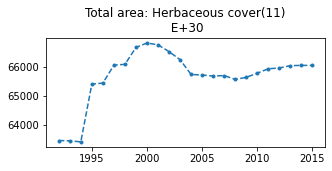

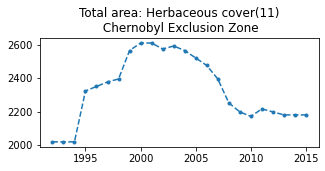

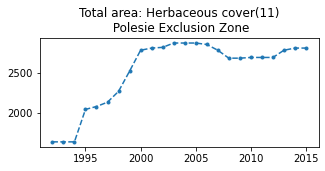

In [15]:
display_class_metric("E+60", 11, "total_area")
display_class_metric("E+30", 11, "total_area")
display_class_metric("Chernobyl Exclusion Zone", 11, "total_area")
display_class_metric("Polesie Exclusion Zone", 11, "total_area")

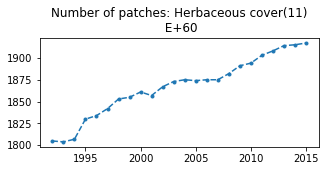

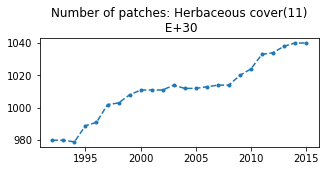

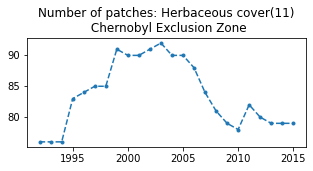

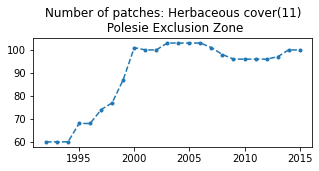

In [16]:
display_class_metric("E+60", 11, "number_of_patches")
display_class_metric("E+30", 11, "number_of_patches")
display_class_metric("Chernobyl Exclusion Zone", 11, "number_of_patches")
display_class_metric("Polesie Exclusion Zone", 11, "number_of_patches")

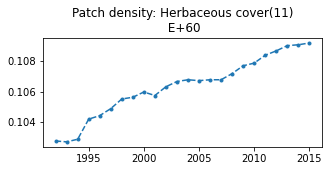

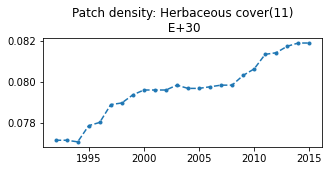

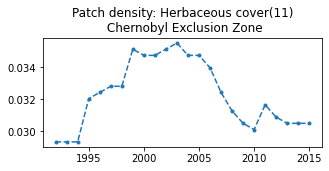

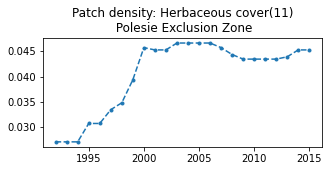

In [21]:
display_class_metric("E+60", 11, "patch_density")
display_class_metric("E+30", 11, "patch_density")
display_class_metric("Chernobyl Exclusion Zone", 11, "patch_density")
display_class_metric("Polesie Exclusion Zone", 11, "patch_density")

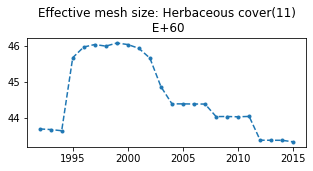

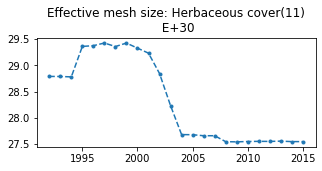

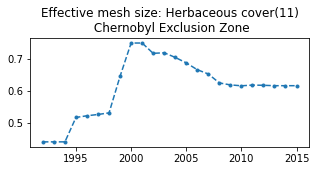

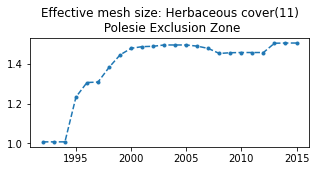

In [17]:
display_class_metric("E+60", 11, "effective_mesh_size")
display_class_metric("E+30", 11, "effective_mesh_size")
display_class_metric("Chernobyl Exclusion Zone", 11, "effective_mesh_size")
display_class_metric("Polesie Exclusion Zone", 11, "effective_mesh_size")

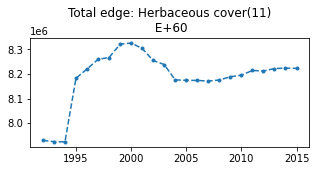

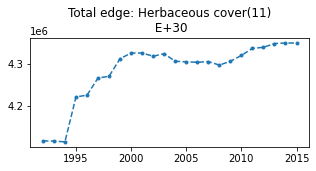

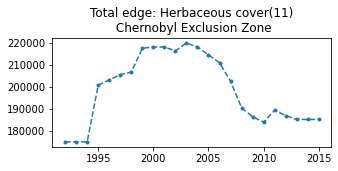

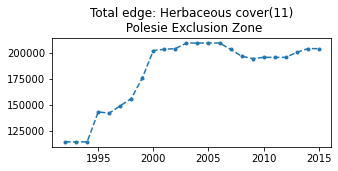

In [18]:
display_class_metric("E+60", 11, "total_edge")
display_class_metric("E+30", 11, "total_edge")
display_class_metric("Chernobyl Exclusion Zone", 11, "total_edge")
display_class_metric("Polesie Exclusion Zone", 11, "total_edge")

For both the buffer areas, herbaceous cover became more fragmented with the smaller MESH. This could ber caused by the increasing use of land  for farm and urban areas.

For CEZ and PEZ, generally, the herbaceous cover was defragmented with the larger MESH compared to that at the beginning. Herbaceous cover is the natural greenland without human interference. The defragmented herbaceous cover indicated the less human activities in the exclusion region.

### 2.1.3 Urban areas

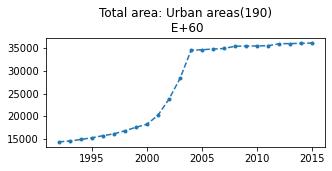

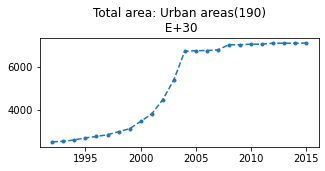

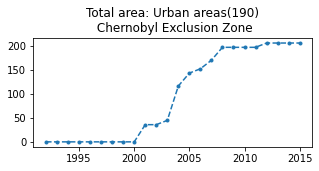

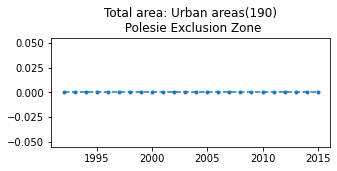

In [20]:
display_class_metric("E+60", 190, "total_area")
display_class_metric("E+30", 190, "total_area")
display_class_metric("Chernobyl Exclusion Zone", 190, "total_area")
display_class_metric("Polesie Exclusion Zone", 190, "total_area")

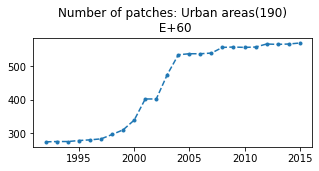

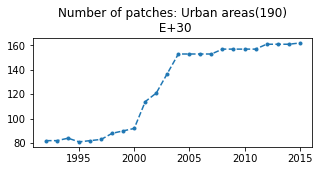

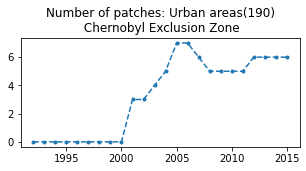

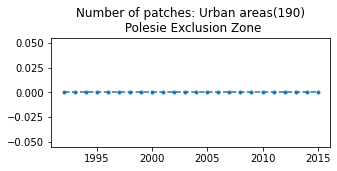

In [21]:
display_class_metric("E+60", 190, "number_of_patches")
display_class_metric("E+30", 190, "number_of_patches")
display_class_metric("Chernobyl Exclusion Zone", 190, "number_of_patches")
display_class_metric("Polesie Exclusion Zone", 190, "number_of_patches")

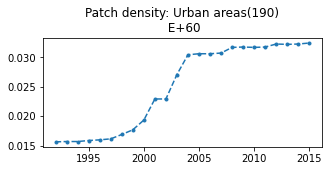

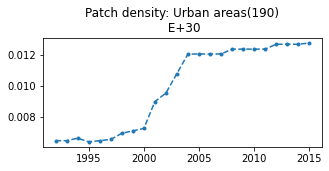

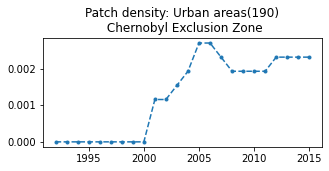

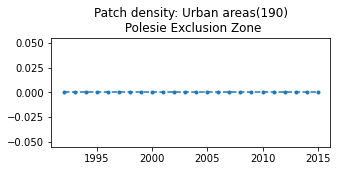

In [22]:
display_class_metric("E+60", 190, "patch_density")
display_class_metric("E+30", 190, "patch_density")
display_class_metric("Chernobyl Exclusion Zone", 190, "patch_density")
display_class_metric("Polesie Exclusion Zone", 190, "patch_density")

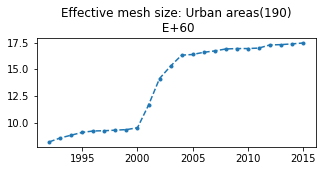

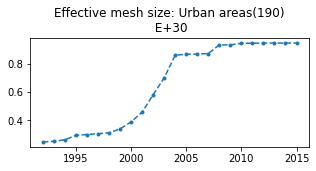

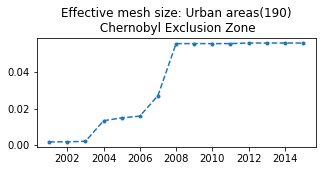

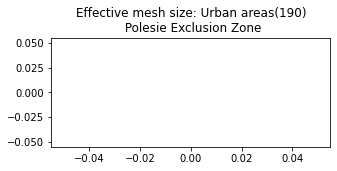

In [22]:
display_class_metric("E+60", 190, "effective_mesh_size")
display_class_metric("E+30", 190, "effective_mesh_size")
display_class_metric("Chernobyl Exclusion Zone", 190, "effective_mesh_size")
display_class_metric("Polesie Exclusion Zone", 190, "effective_mesh_size")

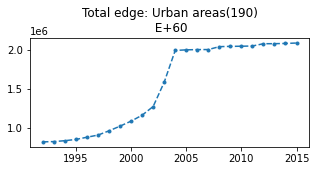

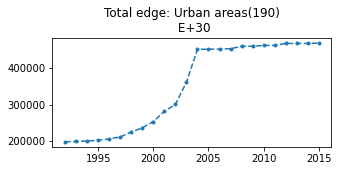

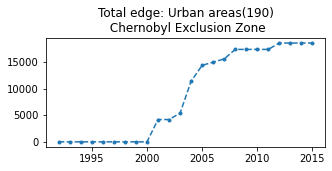

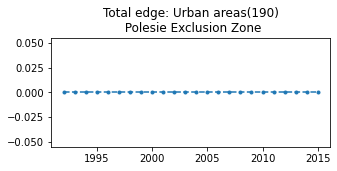

In [17]:
display_class_metric("E+60", 190, "total_edge")
display_class_metric("E+30", 190, "total_edge")
display_class_metric("Chernobyl Exclusion Zone", 190, "total_edge")
display_class_metric("Polesie Exclusion Zone", 190, "total_edge")

From 2000 to 2005, there was a dramatical increase of the urban areas for the two buffer areas and Chernobyl Exclusion Zone. The urban places in E+60 area experienced the greatest increase among the three areas, from 15000 ha to 35000 ha for the total area. Also, E+30 area had had more than 6000 ha urban area due to the growth during the period. Though Chernobyl Exclusion Zone had a upward trend for the urban area, it only grew from 0 to 200 ha in 2010 and kept almost stable after that year. 

Sum up:
1. E+60 area increased the most for urban region during the 14 years, corresponding to the most active anthropogenic activities.
2. Though Chernobyl Exclusion Zone experienced the increase for urban region, the scale was quite small.
3. For the whole region, there was a dramatical growth from 2000 to 2005. This was related to the local change which is unkown.
4. There is no data for Polesie Exclusion Zone.

### 2.1.4 Mosaic cropland (>50%)/natural vegetation (tree, shrub, herbaceous cover)(<50%)

This class equal to 50% Managed grassland, 10% Broadleaved Evergreen, Broadleaved Deciduous, Needleleaved Evergreen, Needleleaved Deciduous, Natural Grassland.


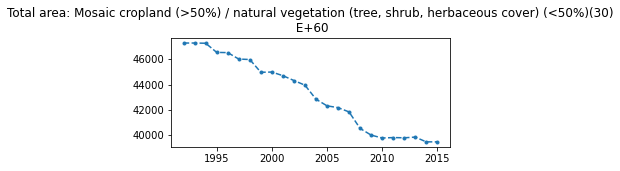

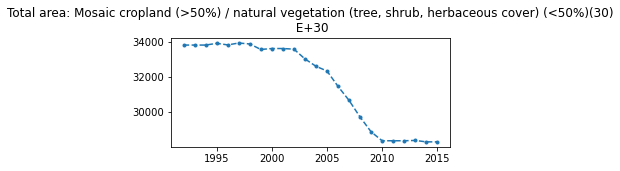

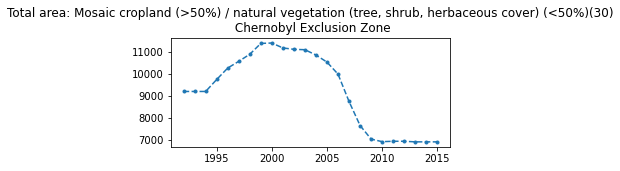

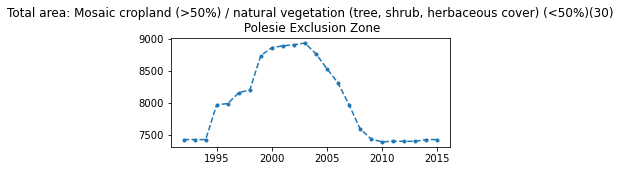

In [25]:
display_class_metric("E+60", 30, "total_area")
display_class_metric("E+30", 30, "total_area")
display_class_metric("Chernobyl Exclusion Zone", 30, "total_area")
display_class_metric("Polesie Exclusion Zone", 30, "total_area")

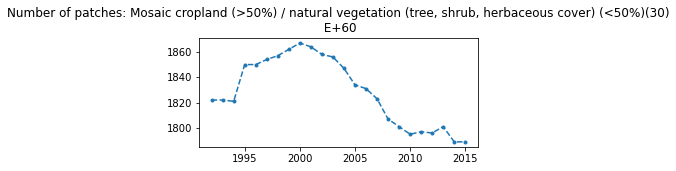

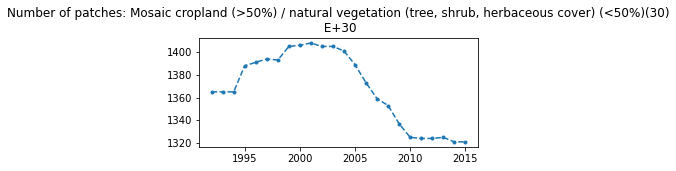

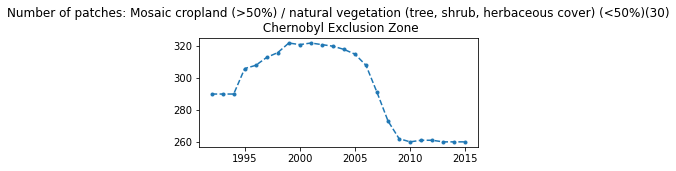

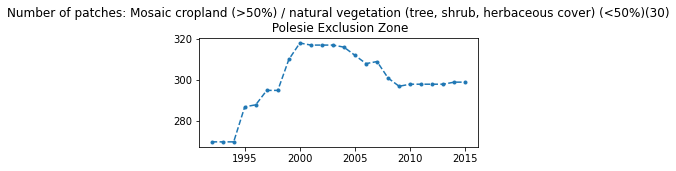

In [26]:
display_class_metric("E+60", 30, "number_of_patches")
display_class_metric("E+30", 30, "number_of_patches")
display_class_metric("Chernobyl Exclusion Zone", 30, "number_of_patches")
display_class_metric("Polesie Exclusion Zone", 30, "number_of_patches")

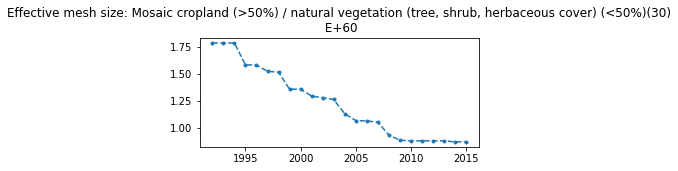

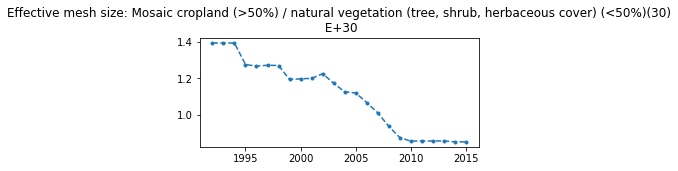

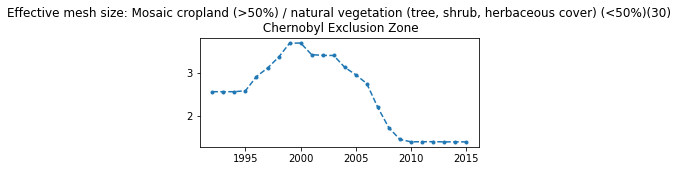

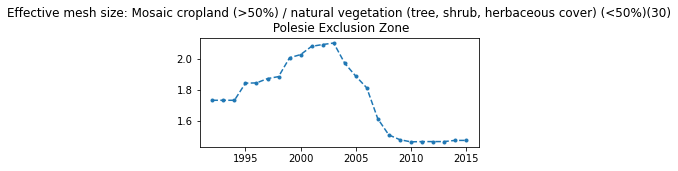

In [27]:
display_class_metric("E+60", 30, "effective_mesh_size")
display_class_metric("E+30", 30, "effective_mesh_size")
display_class_metric("Chernobyl Exclusion Zone", 30, "effective_mesh_size")
display_class_metric("Polesie Exclusion Zone", 30, "effective_mesh_size")

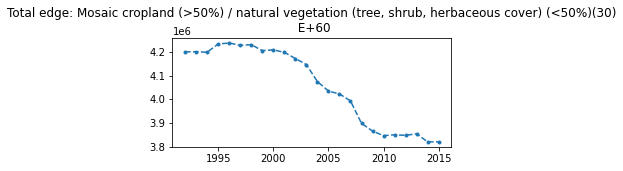

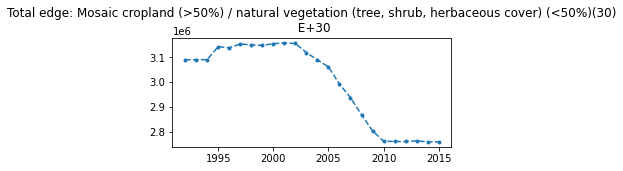

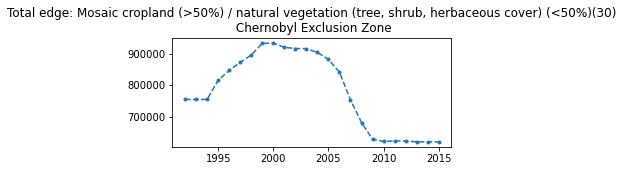

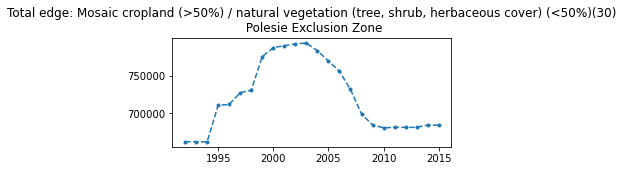

In [16]:
display_class_metric("E+60", 30, "total_edge")
display_class_metric("E+30", 30, "total_edge")
display_class_metric("Chernobyl Exclusion Zone", 30, "total_edge")
display_class_metric("Polesie Exclusion Zone", 30, "total_edge")

This type of landcover class can indicate the process of cropland converting to natural vegetation. 

For CEZ and PEZ, this land class experienced an increase of the number of patches at first and then a reduction of the patches. This indicated that at first there were lots of mixing between cropland and natural vegetation, and they gradually converted to natural vegetation. 

MESH of the four areas all had a reduction during the period, showing the more and more fragmented of this landcover class. This was caused by the decrease of this class.

### 2.1.5 Mosaic natural vegetation (tree, shrub, herbaceous cover) (>50%) / cropland (<50%)

This class equal to 40% Managed grassland, 10% Broadleaved Evergreen, Broadleaved Deciduous, Needleleaved Evergreen, Needleleaved Deciduous, 20% Natural Grassland.

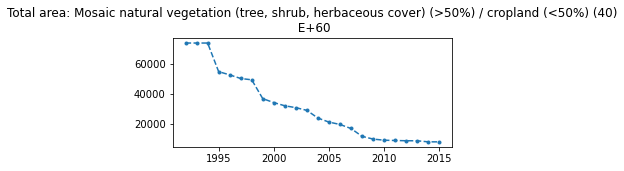

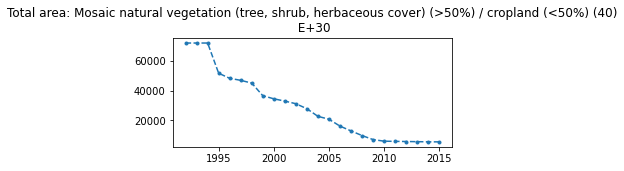

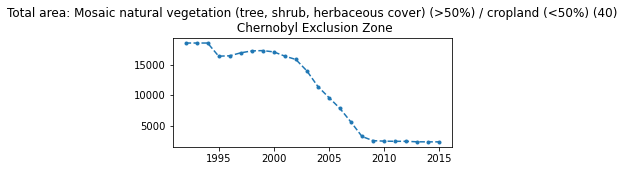

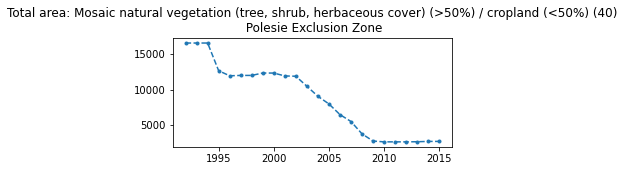

In [30]:
display_class_metric("E+60", 40, "total_area")
display_class_metric("E+30", 40, "total_area")
display_class_metric("Chernobyl Exclusion Zone", 40, "total_area")
display_class_metric("Polesie Exclusion Zone", 40, "total_area")

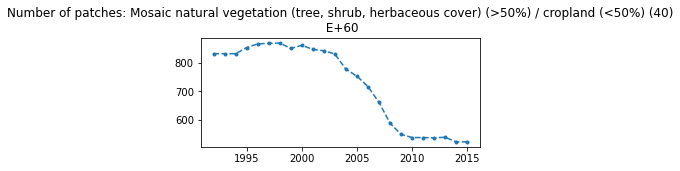

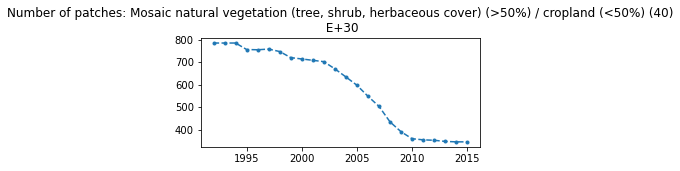

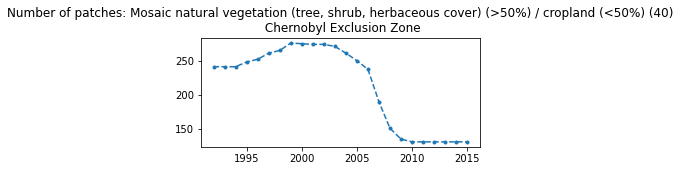

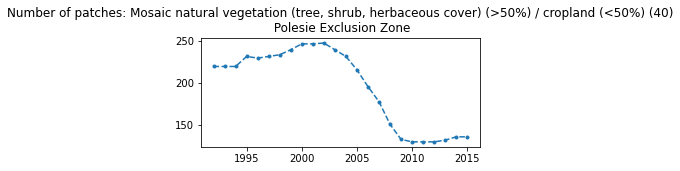

In [31]:
display_class_metric("E+60", 40, "number_of_patches")
display_class_metric("E+30", 40, "number_of_patches")
display_class_metric("Chernobyl Exclusion Zone", 40, "number_of_patches")
display_class_metric("Polesie Exclusion Zone", 40, "number_of_patches")

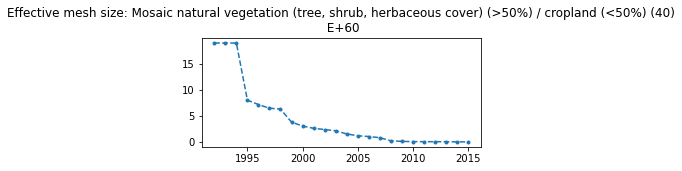

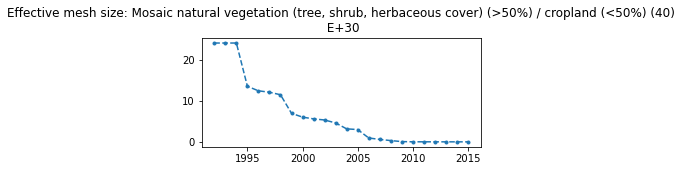

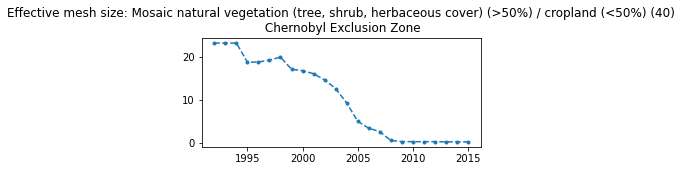

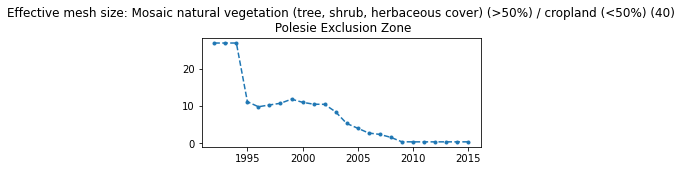

In [32]:
display_class_metric("E+60", 40, "effective_mesh_size")
display_class_metric("E+30", 40, "effective_mesh_size")
display_class_metric("Chernobyl Exclusion Zone", 40, "effective_mesh_size")
display_class_metric("Polesie Exclusion Zone", 40, "effective_mesh_size")

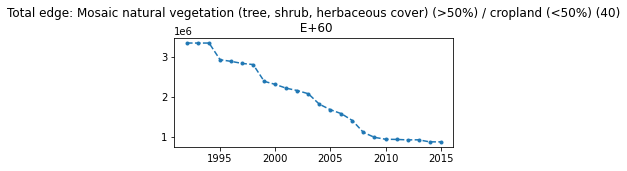

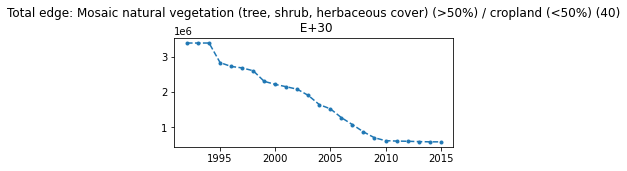

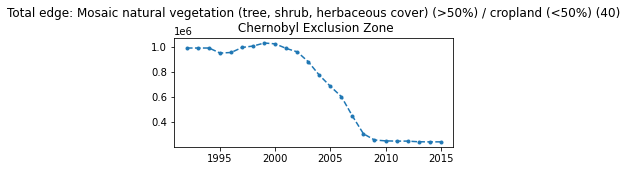

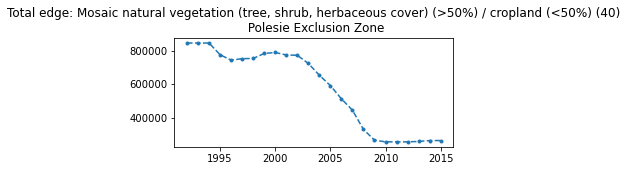

In [15]:
display_class_metric("E+60", 40, "total_edge")
display_class_metric("E+30", 40, "total_edge")
display_class_metric("Chernobyl Exclusion Zone", 40, "total_edge")
display_class_metric("Polesie Exclusion Zone", 40, "total_edge")

### 2.1.6 Tree cover, broadleaved, deciduous, closed to open (>15%)

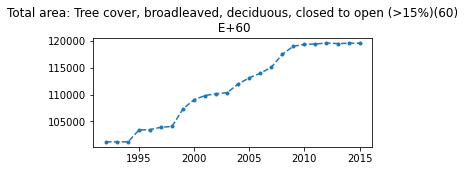

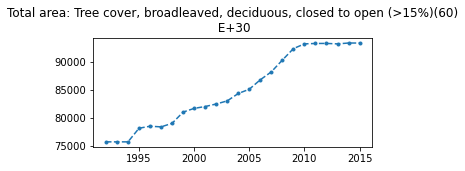

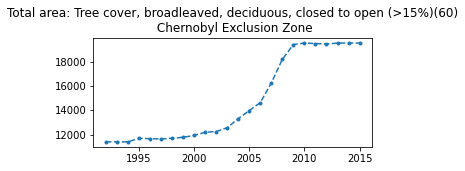

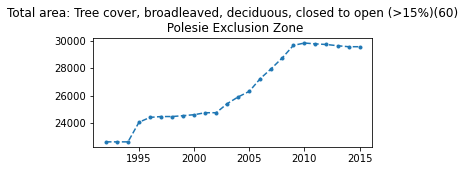

In [8]:
display_class_metric("E+60", 60, "total_area")
display_class_metric("E+30", 60, "total_area")
display_class_metric("Chernobyl Exclusion Zone", 60, "total_area")
display_class_metric("Polesie Exclusion Zone", 60, "total_area")

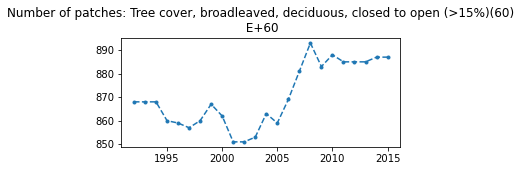

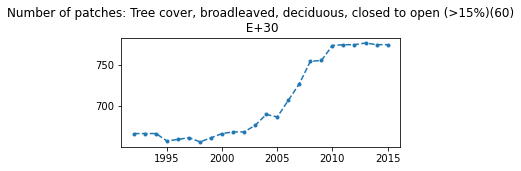

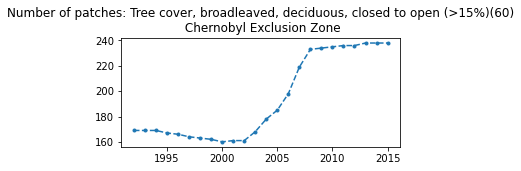

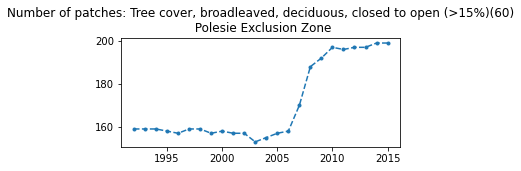

In [9]:
display_class_metric("E+60", 60, "number_of_patches")
display_class_metric("E+30", 60, "number_of_patches")
display_class_metric("Chernobyl Exclusion Zone", 60, "number_of_patches")
display_class_metric("Polesie Exclusion Zone", 60, "number_of_patches")

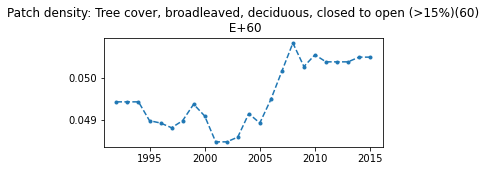

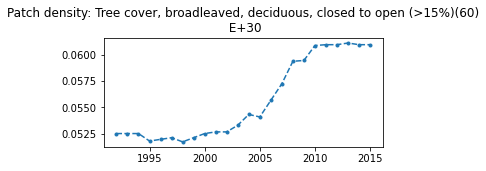

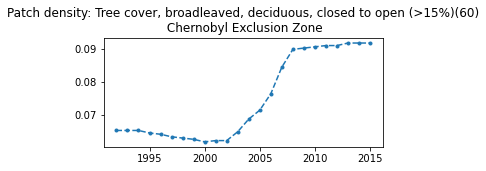

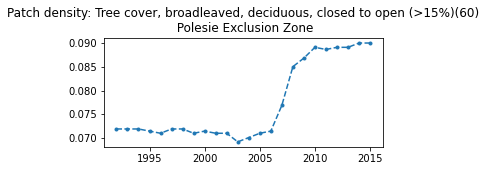

In [13]:
display_class_metric("E+60", 60, "patch_density")
display_class_metric("E+30", 60, "patch_density")
display_class_metric("Chernobyl Exclusion Zone", 60, "patch_density")
display_class_metric("Polesie Exclusion Zone", 60, "patch_density")

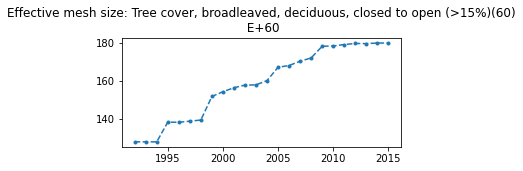

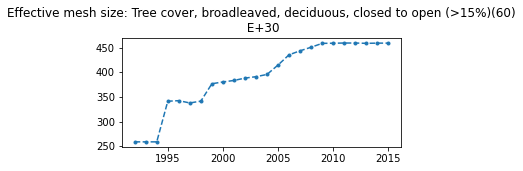

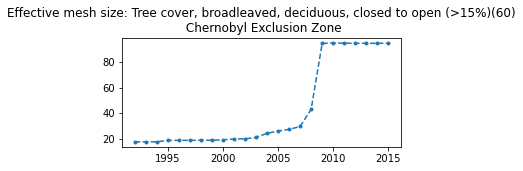

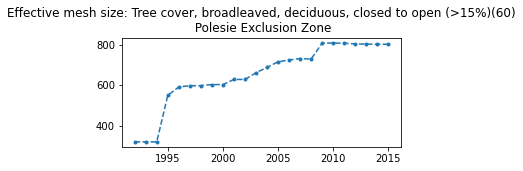

In [10]:
display_class_metric("E+60", 60, "effective_mesh_size")
display_class_metric("E+30", 60, "effective_mesh_size")
display_class_metric("Chernobyl Exclusion Zone", 60, "effective_mesh_size")
display_class_metric("Polesie Exclusion Zone", 60, "effective_mesh_size")

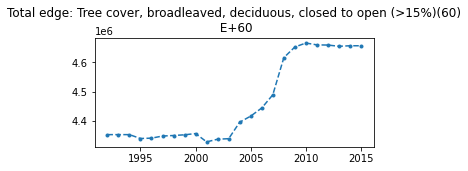

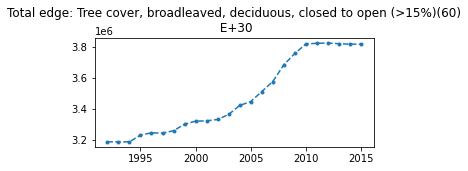

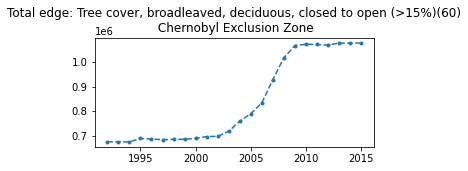

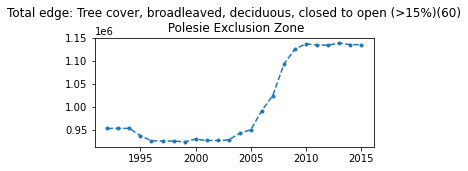

In [14]:
display_class_metric("E+60", 60, "total_edge")
display_class_metric("E+30", 60, "total_edge")
display_class_metric("Chernobyl Exclusion Zone", 60, "total_edge")
display_class_metric("Polesie Exclusion Zone", 60, "total_edge")

From patch density, the broadleaved tree cover in CEZ and PCE was more fragmented than the two buffer zones.

According to the patch metrics, they show that there were more and more broadleaved tree cover in all four areas, and they became more fragmented. However, based on MESH, the values kept increasing during the period, indicating the defragmentation. 

These are conflicted, and I'm quite confused.